# Overview

Kobe Bryant marked his retirement from the NBA by scoring 60 points in his final game as a Los Angeles Laker on Wednesday, April 12, 2016. Drafted into the NBA at the age of 17, Kobe earned the sport’s highest accolades throughout his long career.

Given complete data on 25697 shots, our mission is to predict his his probability of making 5000 other shots. Scores are calculated based off of "log_loss".

In [1]:
import csv
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.mixture import GMM
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_columns', 999)
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/hechengwang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,30697,30697.000000
mean,249.190800,24764065.868065,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1610612747,15349.000000
std,150.003712,7755174.890198,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0,8861.604943
min,2.000000,20000012.000000,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1610612747,1.000000
25%,110.000000,20500077.000000,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1610612747,7675.000000
50%,253.000000,20900354.000000,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1610612747,15349.000000
75%,368.000000,29600474.000000,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1610612747,23023.000000
max,659.000000,49900088.000000,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1610612747,30697.000000


I've split up my analysis on "Shot Type", "Location", "Time", and "Game".

# Analysis - Shot Type

In [5]:
print df['action_type'].unique()
print df['combined_shot_type'].unique()

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Driving Layup Shot' 'Reverse Layup Shot' 'Reverse Dunk Shot'
 'Slam Dunk Shot' 'Turnaround Jump Shot' 'Tip Shot' 'Running Hook Shot'
 'Alley Oop Dunk Shot' 'Dunk Shot' 'Alley Oop Layup shot'
 'Running Dunk Shot' 'Driving Finger Roll Shot' 'Running Layup Shot'
 'Finger Roll Shot' 'Fadeaway Jump Shot' 'Follow Up Dunk Shot' 'Hook Shot'
 'Turnaround Hook Shot' 'Running Tip Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Reverse Layup Shot'
 'Driving Finger Roll Layup Shot' 'Fadeaway Bank shot' 'Pullup Jump shot'
 'Finger Roll Layup Shot' 'Turnaround Fadeaway shot'
 'Driving Reverse Layup Shot' 'Driving Slam Dunk Shot'
 'Step Back Jump shot' 'Reverse Slam Dunk Shot' 'Turnaround Bank shot'
 'Running Finger Roll Layup Shot' 'Floating Jump shot'
 'Putback Slam Dunk Shot' 'Running Bank shot' 'Driving Bank shot'
 'Putback Layup Shot'

It looks like `action_type` is the granular version of `combined_shot_type`. Let's see his accuracy on the granular and the combined level.

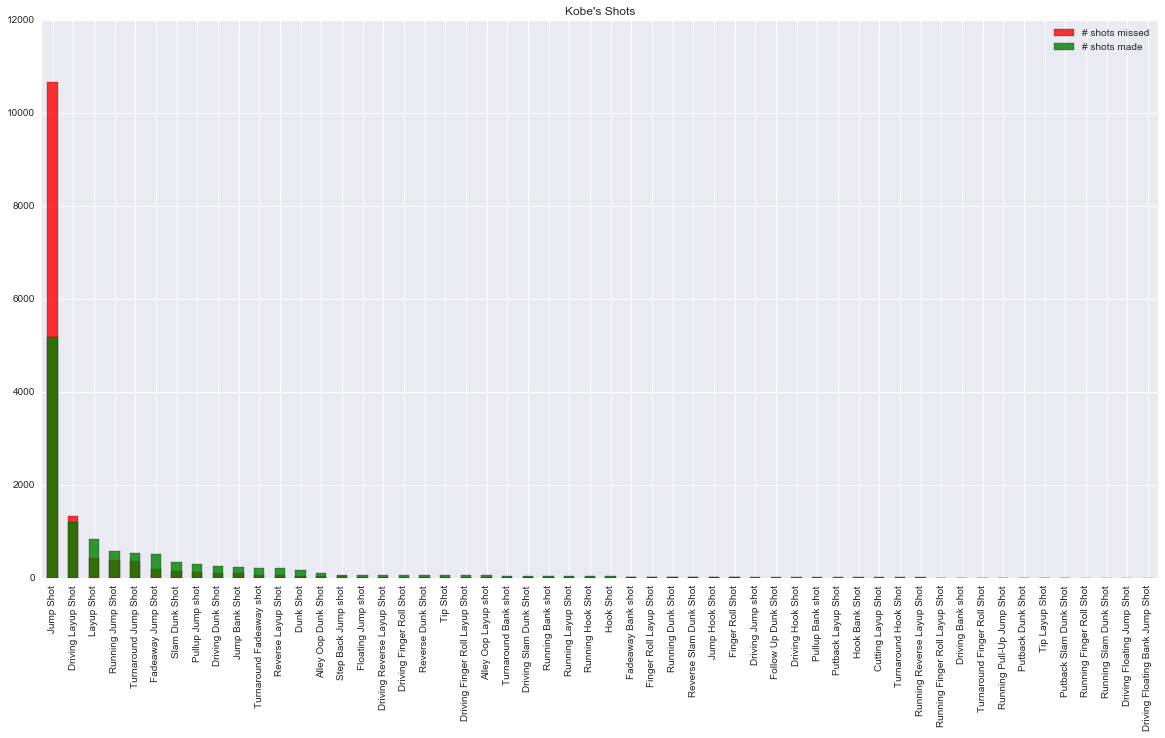

In [6]:
plt.figure(figsize = (20, 10))
action_type_hist = df['action_type'][df['shot_made_flag'] ==0].value_counts()
action_type_hist.plot(kind = 'bar', color = 'r', alpha = 0.8)
action_type_hist = df['action_type'][df['shot_made_flag'] ==1].value_counts()
action_type_hist.plot(kind = 'bar', color = 'g', alpha = 0.8)
plt.title('Kobe\'s Shots')
plt.legend(['# shots missed', '# shots made'])
plt.show()

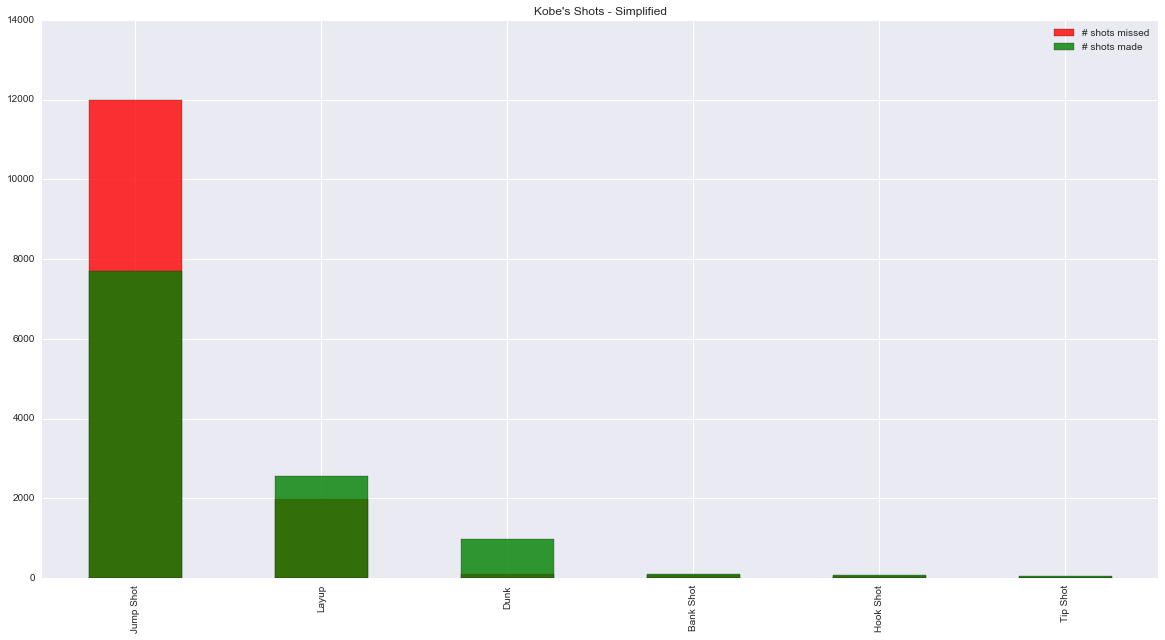

In [7]:
plt.figure(figsize = (20, 10))
action_type_hist = df['combined_shot_type'][df['shot_made_flag'] ==0].value_counts()
action_type_hist.plot(kind = 'bar', color = 'r', alpha = 0.8)
action_type_hist = df['combined_shot_type'][df['shot_made_flag'] ==1].value_counts()
action_type_hist.plot(kind = 'bar', color = 'g', alpha = 0.8)
plt.title('Kobe\'s Shots - Simplified')
plt.legend(['# shots missed', '# shots made'])
plt.show()

In [8]:
shots_group = pd.DataFrame(df['combined_shot_type'].groupby(
        [df['combined_shot_type'], df['action_type']]).count())
shots_group

0
combined_shot_type action_type                              
Bank Shot          Driving Bank shot                       5
                   Hook Bank Shot                          5
                   Pullup Bank shot                       12
                   Running Bank shot                      48
                   Turnaround Bank shot                   71
Dunk               Alley Oop Dunk Shot                   122
                   Driving Dunk Shot                     310
                   Driving Slam Dunk Shot                 48
                   Dunk Shot                             262
                   Follow Up Dunk Shot                    15
                   Putback Dunk Shot                       5
                   Putback Slam Dunk Shot                  2
                   Reverse Dunk Shot                      75
                   Reverse Slam Dunk Shot                 16
                   Running Dunk Shot                      19
                   Running Slam Dunk Shot                  1
                   Slam Dunk Shot                        411
Hook Shot          Driving Hook Shot                      14
                   Hook Shot                              84
                   Running Hook Shot                      41
                   Turnaround Hook Shot                   14
Jump Shot          Driving Floating Bank Jump Shot         1
                   Driving Floating Jump Shot              5
                   Driving Jump shot                      28
                   Fadeaway Bank shot                     31
                   Fadeaway Jump Shot                   1048
                   Floating Jump shot                    114
                   Jump Bank Shot                        333
                   Jump Hook Shot                         24
                   Jump Shot                           18880
                   Pullup Jump shot                      476
                   Running Jump Shot                     926
                   Running Pull-Up Jump Shot               4
                   Step Back Jump shot                   118
                   Turnaround Fadeaway Bank Jump Shot      1
                   Turnaround Fadeaway shot              439
                   Turnaround Jump Shot                 1057
Layup              Alley Oop Layup shot                   80
                   Cutting Finger Roll Layup Shot          1
                   Cutting Layup Shot                      6
                   Driving Finger Roll Layup Shot         69
                   Driving Finger Roll Shot               82
                   Driving Layup Shot                   1978
                   Driving Reverse Layup Shot             97
                   Finger Roll Layup Shot                 33
                   Finger Roll Shot                       28
                   Layup Shot                           2567
                   Putback Layup Shot                     15
                   Reverse Layup Shot                    395
                   Running Finger Roll Layup Shot          6
                   Running Finger Roll Shot                4
                   Running Layup Shot                     72
                   Running Reverse Layup Shot             11
                   Tip Layup Shot                          2
                   Turnaround Finger Roll Shot             2
Tip Shot           Running Tip Shot                        2
                   Tip Shot                              182

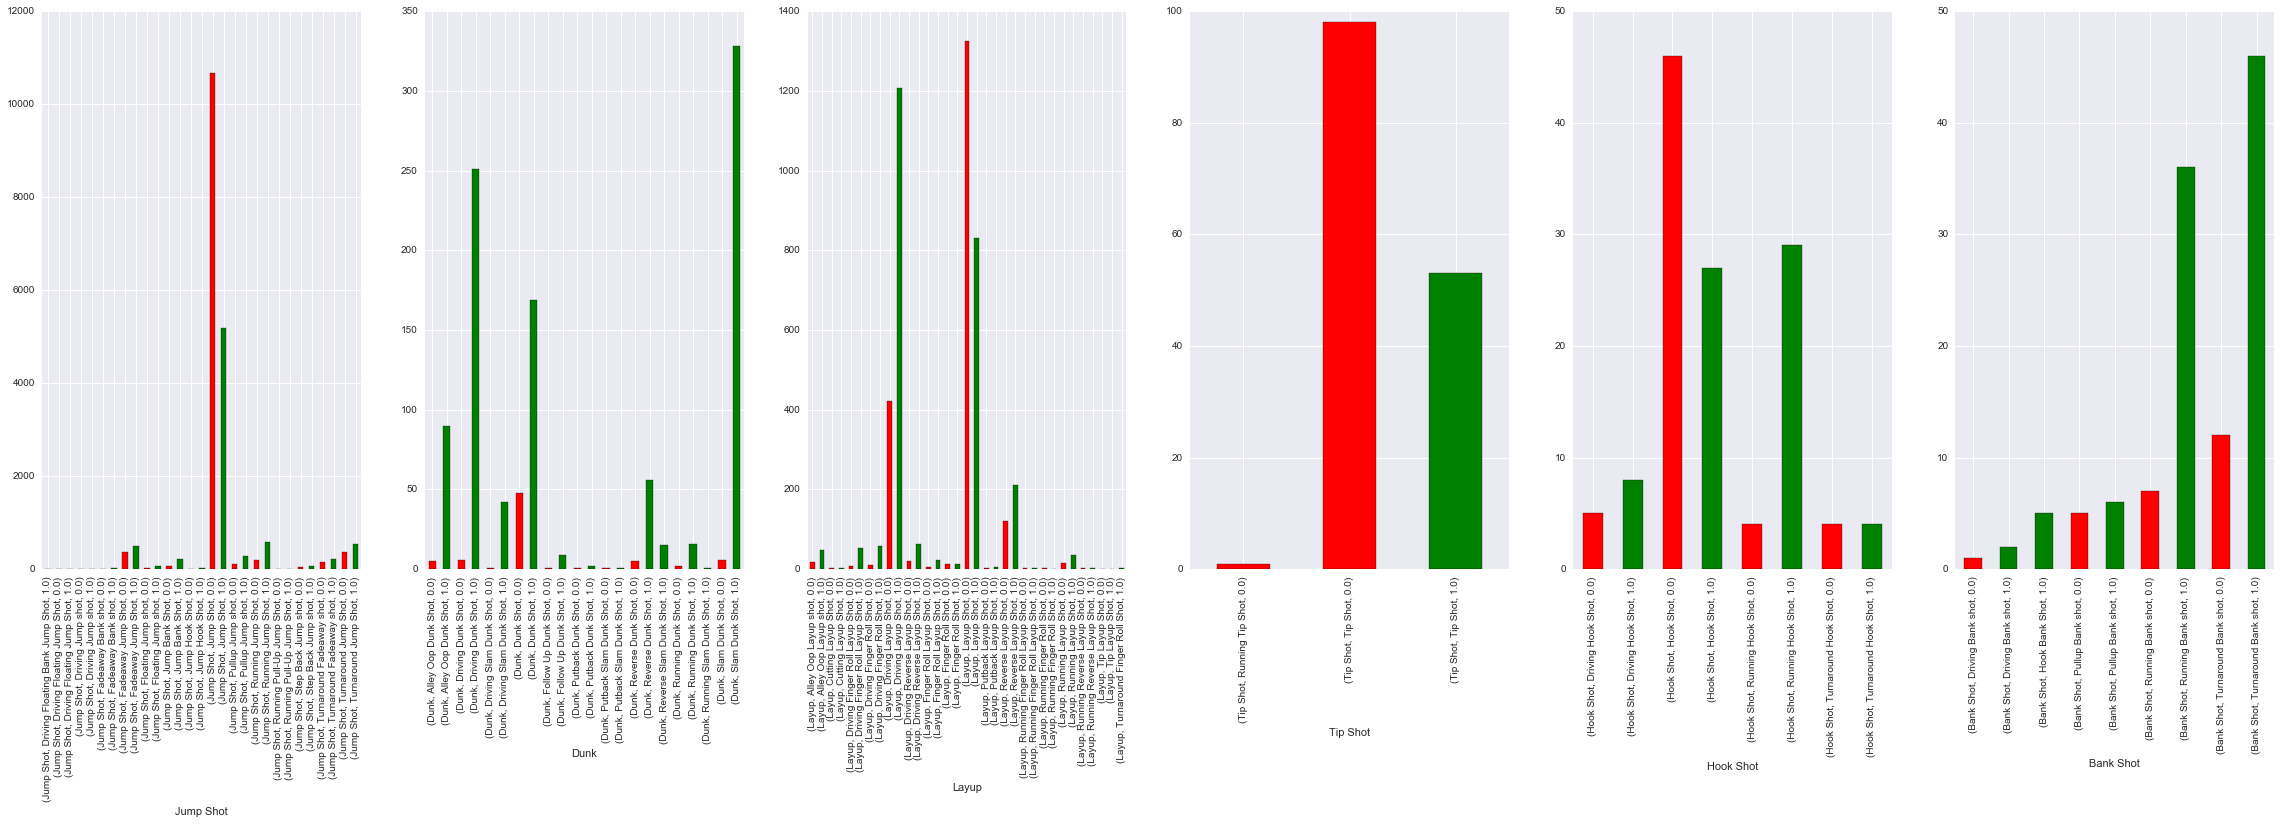

In [9]:
i = 1
plt.figure(figsize = (40, 10))
for shot_type in df['combined_shot_type'].unique():
    plt.subplot(1, 6, i)
    group = df['combined_shot_type'][df['combined_shot_type'] == shot_type].groupby(
        [df['combined_shot_type'], df['action_type'], df['shot_made_flag']]).count()
    group.plot(kind = 'bar', color = np.where(group.index.labels[2] == 0, 'r', 'g'))
    plt.xlabel(shot_type)
    i +=1

It seems like Kobe mostly does jump shots, with about a 30% accuracy. He's much better at driving layups, with around 70% accuracy, although regular lay ups are around 40% accuracy. As expected, he rarely misses his dunks.

# Analysis - Location


It looks like every loc_x and loc_y correspond to the 1/10th feet from the hoop. The following is a heatmap of Kobe's shots based on # and % made.

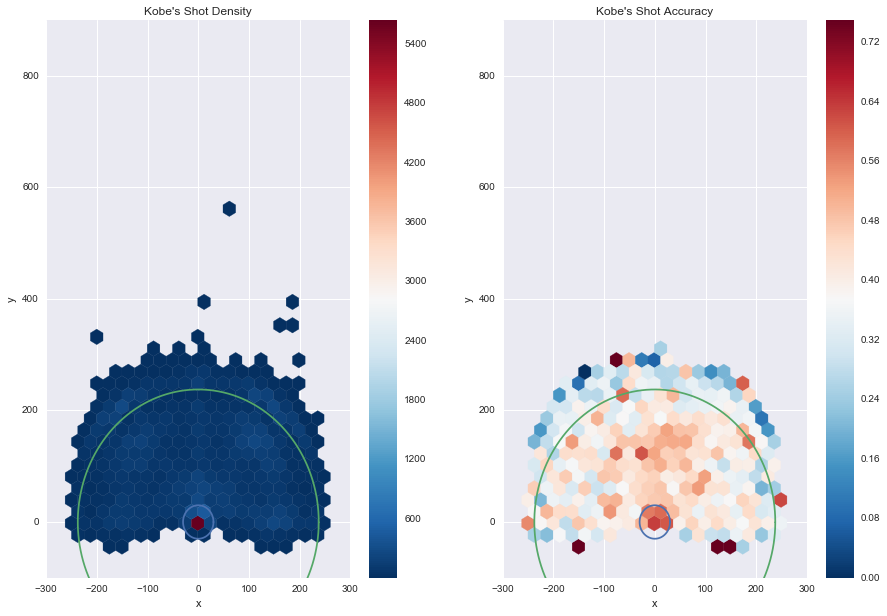

In [10]:
plt.figure(figsize = (15,10))
radians = np.arange(0, 2*np.pi, 0.01)

plt.subplot(1, 2, 1)
plt.hexbin(df['loc_x'], df['loc_y'], mincnt = 3, gridsize = (20,20), cmap=plt.cm.RdBu_r);
plt.plot(30*np.cos(radians), 30*np.sin(radians), label = 'paint')
#plt.plot(150*np.cos(radians), 150*np.sin(radians), label = 'free')
plt.plot(237.5*np.cos(radians), 237.5*np.sin(radians), label = 'three')
plt.xlim([-300, 300]);
plt.ylim([-100, 900]);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Kobe's Shot Density");
plt.colorbar();


plt.subplot(1, 2, 2)
plt.hexbin(df['loc_x'], df['loc_y'], mincnt = 3, C = df['shot_made_flag'], gridsize = (20,20), cmap=plt.cm.RdBu_r);
plt.plot(30*np.cos(radians), 30*np.sin(radians), label = 'paint')
#plt.plot(150*np.cos(radians), 150*np.sin(radians), label = 'free')
plt.plot(237.5*np.cos(radians), 237.5*np.sin(radians), label = 'three')
plt.xlim([-300, 300]);
plt.ylim([-100, 900]);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Kobe's Shot Accuracy");
plt.colorbar();


Looks like the most dense cluster of Kobe's shots are right under the net (3 feet radius). Let's see how well he does with those.

In [11]:
def get_pit(shot, radius):
    x = shot['loc_x']
    y = shot['loc_y']
    if ((radius**2) >= (x**2 + y**2) and y > 0):
        return 1
    else:
        return 0
def get_three(shot, radius):
    x = shot['loc_x']
    y = shot['loc_y']
    if ((radius**2) <= (x**2 + y**2) and y > 0):
        return 1
    else:
        return 0

In [12]:
df['pit'] = df.apply(lambda x: get_pit(x, 30), axis = 1)
df[df['pit'] == 1].describe()['shot_made_flag']

count    1033.000000
mean        0.622459
std         0.485007
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: shot_made_flag, dtype: float64

Note that we have 62% accuracy under the net, not bad!
What about 3 pointers?

In [13]:
df['three_points'] = df.apply(lambda x: get_three(x, 237.5), axis = 1)
df[df['three_points'] == 1].describe()['shot_made_flag']

count    4912.000000
mean        0.326140
std         0.468847
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: shot_made_flag, dtype: float64

A 32% accuracy for those 3s.

In [14]:
df[df['loc_y'] < 0].describe()['shot_made_flag']

count    1290.000000
mean        0.416279
std         0.493132
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: shot_made_flag, dtype: float64

In the shots Kobe takes behind the backboard, he makes 42% of them!

Here's the court again, but with zones, and % numbers.

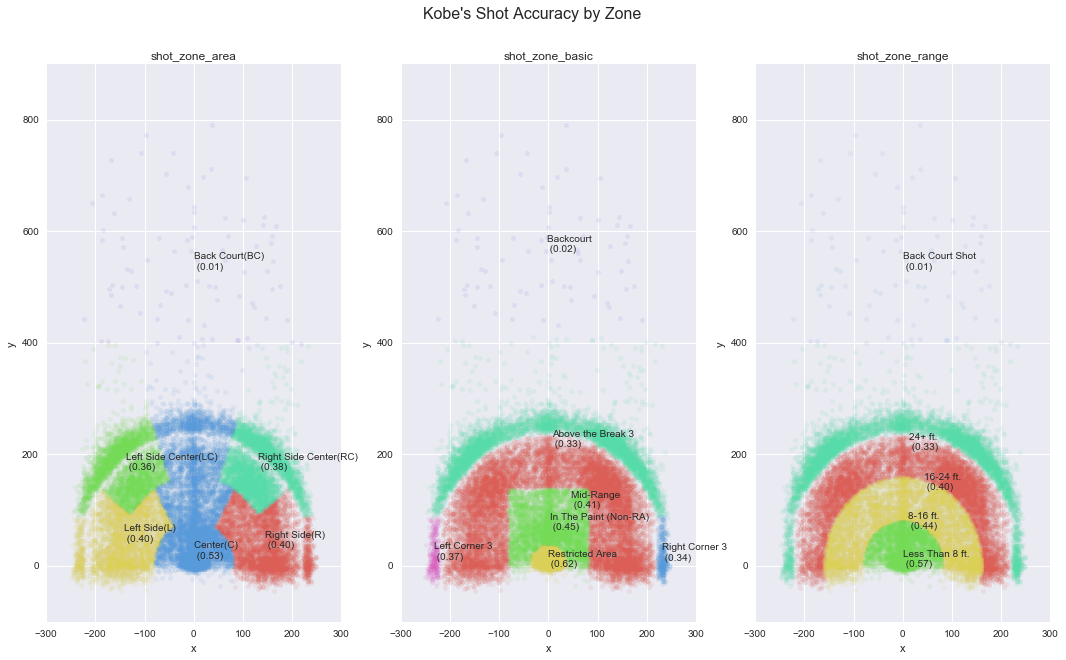

In [15]:
shot_zone_area = df['shot_zone_area'].unique()
shot_zone_basic = df['shot_zone_basic'].unique()
shot_zone_range = df['shot_zone_range'].unique()

plt.figure(figsize = (18,10))
colors = sns.color_palette("hls", 7)
category = [shot_zone_area, shot_zone_basic, shot_zone_range]
category_text = ['shot_zone_area', 'shot_zone_basic', 'shot_zone_range']
cat = 0
plt.suptitle("Kobe's Shot Accuracy by Zone", fontsize = 16);

for zone in category:
    i = 0
    cat += 1
    plt.subplot(1, 3, cat)
    for zone_1 in zone:
        plt.scatter(df['loc_x'][df[category_text[cat - 1]] == zone_1], 
                    df['loc_y'][df[category_text[cat - 1]] == zone_1], 
                    color = colors[i], alpha = 0.1, label = zone_1)
        i += 1
        text_x = np.median(df['loc_x'][df[category_text[cat - 1]] == zone_1])
        text_y = np.median(df['loc_y'][df[category_text[cat - 1]] == zone_1])
        accuracy = np.mean(df['shot_made_flag'][df[category_text[cat - 1]] == zone_1])
        plt.text(text_x, text_y, '%s \n (%.2f)' % (zone_1, accuracy));
        plt.xlim([-300, 300]);
        plt.ylim([-100, 900]);
        plt.xlabel("x");
        plt.ylabel("y");
        plt.title(category_text[cat - 1]);



In [16]:
components = 13

g = GMM(n_components=components, covariance_type='full', random_state = 0)
g.fit(df[['loc_x', 'loc_y']])
df['GMM_Zone'] = g.predict(df[['loc_x', 'loc_y']])

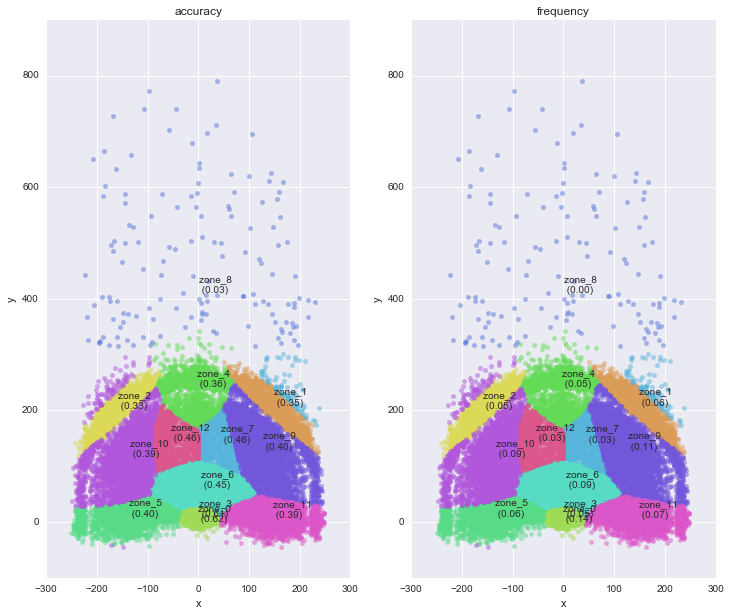

In [17]:
colors = sns.color_palette("hls", components)
plt.figure(figsize=(12, 10))

for i, plot_type in enumerate(['accuracy', 'frequency']):
    plt.subplot(1, 2, i + 1)
    for zone in range(components):
        plt.scatter(df['loc_x'][df['GMM_Zone'] == zone], 
                    df['loc_y'][df['GMM_Zone'] == zone], 
                    color = colors[zone], alpha = 0.5, label = 'zone_' + str(zone))


        text_x = np.median(df['loc_x'][df['GMM_Zone'] == zone])
        text_y = np.median(df['loc_y'][df['GMM_Zone'] == zone])
        if plot_type == 'accuracy':
            accuracy = np.mean(df['shot_made_flag'][df['GMM_Zone'] == zone])
            plt.text(text_x, text_y, '%s \n (%.2f)' % ('zone_' + str(zone), accuracy));
        else:
            frequency = df['shot_made_flag'][df['GMM_Zone'] == zone].count() / float(len(df))
            plt.text(text_x, text_y, '%s \n (%.2f)' % ('zone_' + str(zone), frequency));
        plt.xlim([-300, 300]);
        plt.ylim([-100, 900]);
        plt.xlabel("x");
        plt.ylabel("y");
        plt.title(plot_type)

Here's a graph of Kobe's shot accuracy as a function of distance. It looks like his accuracy follows a parabolic function (spikes at the end are the few half-court shots he made that sunk).

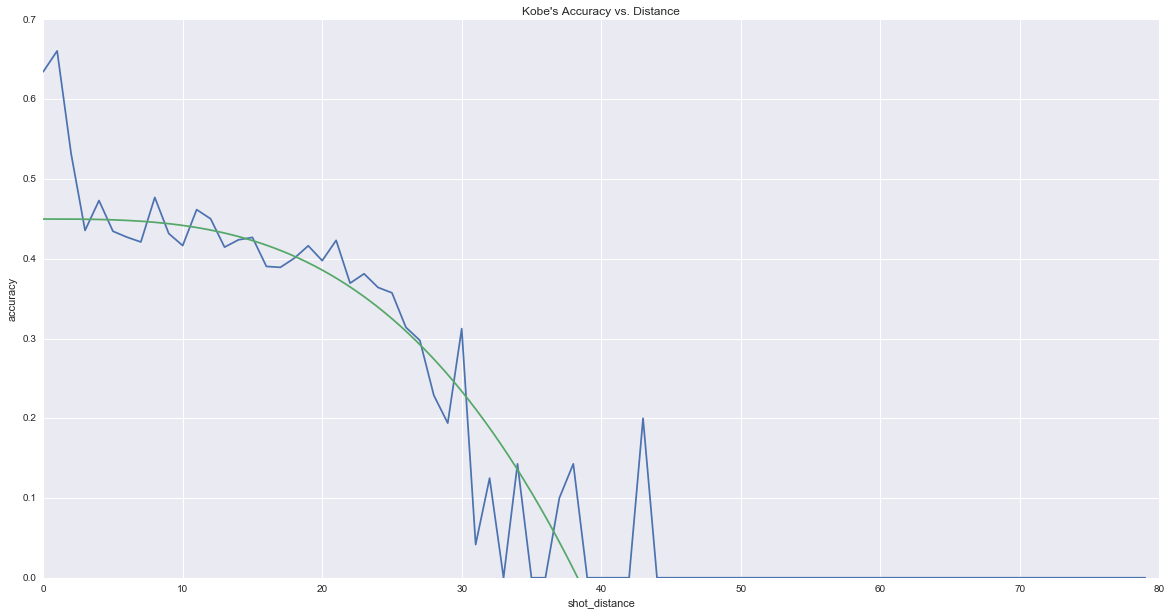

In [18]:
plt.figure(figsize = (20, 10))
shot_dist_ct_counts = pd.crosstab(df['shot_distance'], df['shot_made_flag'])
shot_dist_ct = shot_dist_ct_counts.apply(lambda x: x/x.sum(), axis=1)
plt.plot(shot_dist_ct[1.0]);
plt.xlabel('shot_distance')
plt.ylabel('accuracy')
plt.title("Kobe's Accuracy vs. Distance");
shot_distance = np.arange(0, 39, 0.01)
plt.plot(shot_distance, -(shot_distance/50)**3 + .45)
plt.ylim([0, 0.7]);

# Analysis - Time

The following analysis is shamelessly stolen from Selfish Gene's "Psychology of a Professional Athlete".

In [19]:
df['seconds_into_period'] = 60*(11-df['minutes_remaining'])+(60-df['seconds_remaining'])
df['seconds_into_game'] = (df['period'] <= 4).astype(int)*(df['period']-1)*12*60 + \
    (df['period'] > 4).astype(int)*((df['period']-4)*5*60 + 3*12*60) + df['seconds_into_period']

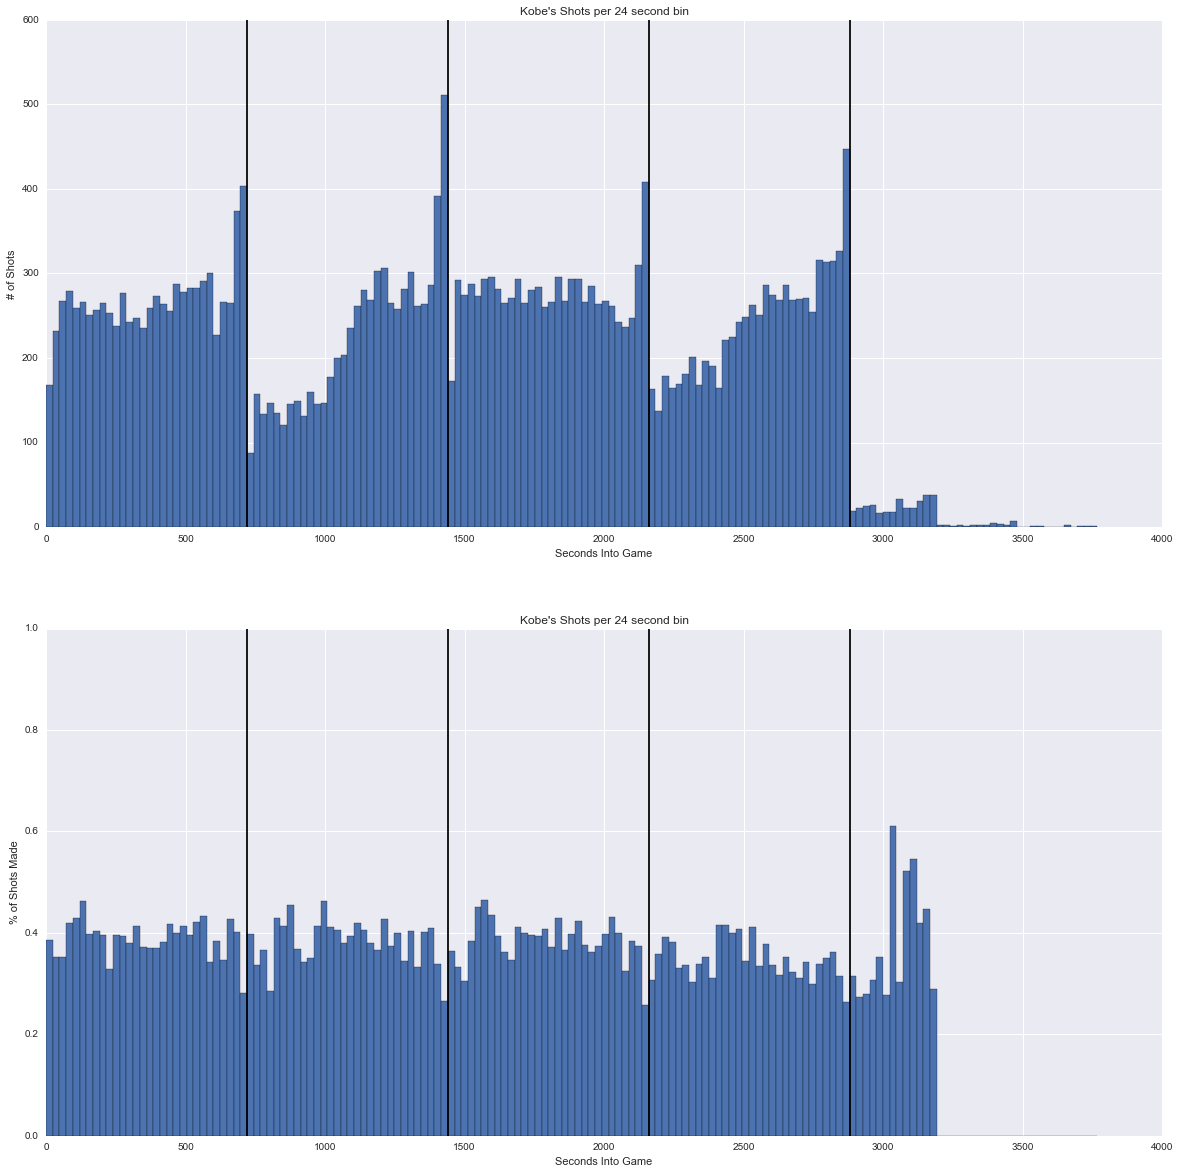

In [20]:
timeBins = np.arange(0,60*(4*12+3*5),24) + 0.01
y, x = np.histogram(df['seconds_into_game'], bins = timeBins)
y_acc, x_acc = np.histogram(df.ix[df['shot_made_flag']==1,'seconds_into_game'], bins=timeBins) 
y_percent = (y_acc.astype(float) / y)
y_percent[y_percent == np.nan] = 0
y_percent[y < 10] = 0

plt.figure(figsize = (20, 20))
plt.subplot(2, 1, 1)
plt.bar(x[:-1], y, width = 24, align='edge');
plt.vlines([range(720, 5*720, 720)], ymin= 0, ymax = 600);
plt.xlabel('Seconds Into Game')
plt.ylabel('# of Shots')
plt.title("Kobe's Shots per 24 second bin");

plt.subplot(2, 1, 2)
plt.bar(x[:-1], y_percent, width = 24, align='edge');
plt.vlines([range(720, 5*720, 720)], ymin= 0, ymax = 1);
plt.xlabel('Seconds Into Game')
plt.ylabel('% of Shots Made')
plt.title("Kobe's Shots per 24 second bin");

In [21]:
df['made_last_shot'] = 0
df['time_from_last_shot'] = 0
for i in range(1, len(df)):
    df.loc[i, 'made_last_shot'] = np.where((df.loc[i - 1, 'shot_made_flag'] == 1) & 
                   (df.loc[i - 1, 'game_id'] == df.loc[i, 'game_id']) & 
                   (df.loc[i - 1, 'period'] == df.loc[i, 'period']), 1, 0)
    df.loc[i, 'time_from_last_shot'] = np.where((df.loc[i - 1, 'game_id'] == df.loc[i, 'game_id']) & 
                                                (df.loc[i - 1, 'period'] == df.loc[i, 'period']),
                                                df.loc[i, 'seconds_into_period'] - df.loc[i - 1, 'seconds_into_period'], 0)

In [22]:
print df[df['made_last_shot'] == 1]['shot_made_flag'].mean()
print df[df['made_last_shot'] == 0]['shot_made_flag'].mean()

0.441584405848
0.44823103877


In [23]:
df[['time_from_last_shot', 'made_last_shot']]

,time_from_last_shot,made_last_shot
0,0,0
1,5,0
2,157,0
3,53,1
4,0,0
5,0,0
6,40,0
7,47,1
8,113,0
9,156,1


While Kobe makes most shots at the end of each quarter (teammates trust him with the last shot), his accuracy on those isn't necessarily great as many of these shots may come from halfcourt. Note that his teammates may have lower shot accuracy were they given the last shot.

# Analysis - Game

In [24]:
df['points_made'] = (df['shot_type'].apply(lambda x: int(x[:1]))*
                        df['shot_made_flag'])
points_per_game = df['points_made'].groupby(df['game_id']).sum()
print "Kobe's average points per game (with the available data) is %.0f." % (np.mean(points_per_game))

Kobe's average points per game (with the available data) is 16.


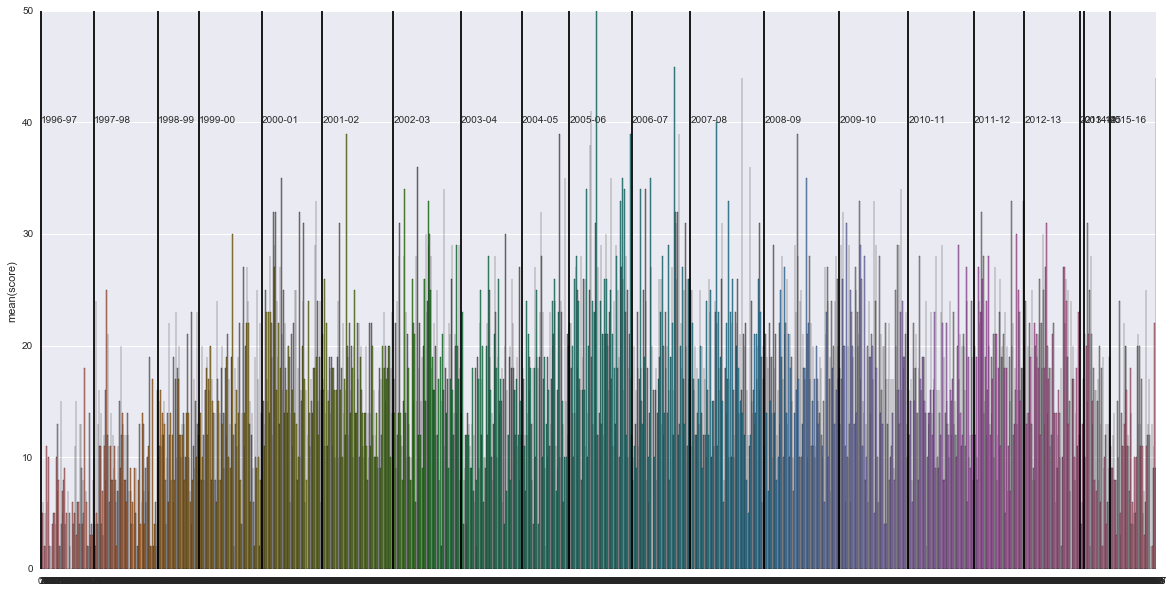

In [25]:
seasons = sorted(df['season'].unique())
df['points_made'] = (df['shot_type'].apply(lambda x: int(x[:1]))*
                        df['shot_made_flag'])
season_points = pd.DataFrame(columns = ['game_id', 'season', 'score'])
i = 0
season_index = []
for season in sorted(seasons):
    df_season = df[df['season'] == season]
    ppgameseason = df_season['points_made'].dropna().groupby([df['game_id'].dropna(), df['season'].dropna()]).sum()
    df_size = len(ppgameseason)
    game_id = ppgameseason.index.levels[0]
    season = [ppgameseason.index.levels[1][0]]*df_size
    score = ppgameseason.values
    df_temp = pd.DataFrame({'game_id':game_id, 'season': season, 'score': score})
    season_index.append(len(season_points))
    season_points = season_points.append(df_temp, ignore_index = True)

plt.figure(figsize = (20, 10));
sns.barplot(x = season_points.index, y = season_points['score']);
for season in season_index:
    plt.plot([season, season], [0, 50], 'k')
    plt.text(season, 40, season_points['season'][season]);

In [26]:
df['away'] = df['matchup'].str.contains('@').astype(int)
acc_away = df['shot_made_flag'].groupby(df['away']).mean()
print "Kobe's accuracy at home is %.2f." % (acc_away[0])
print "Kobe's accuracy away is %.2f." % (acc_away[1])

Kobe's accuracy at home is 0.46.
Kobe's accuracy away is 0.44.


Analysis of shot accuracy per opponent, per action type.

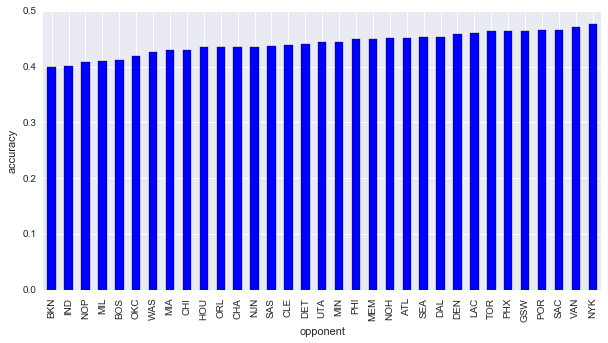

In [27]:
plt.figure(figsize = (10, 5))
acc_opp_total = df['shot_made_flag'].groupby([df['opponent']]).mean()
acc_opp_total = acc_opp_total.sort_values()
acc_opp_total.plot(kind = 'bar')
plt.ylabel('accuracy');

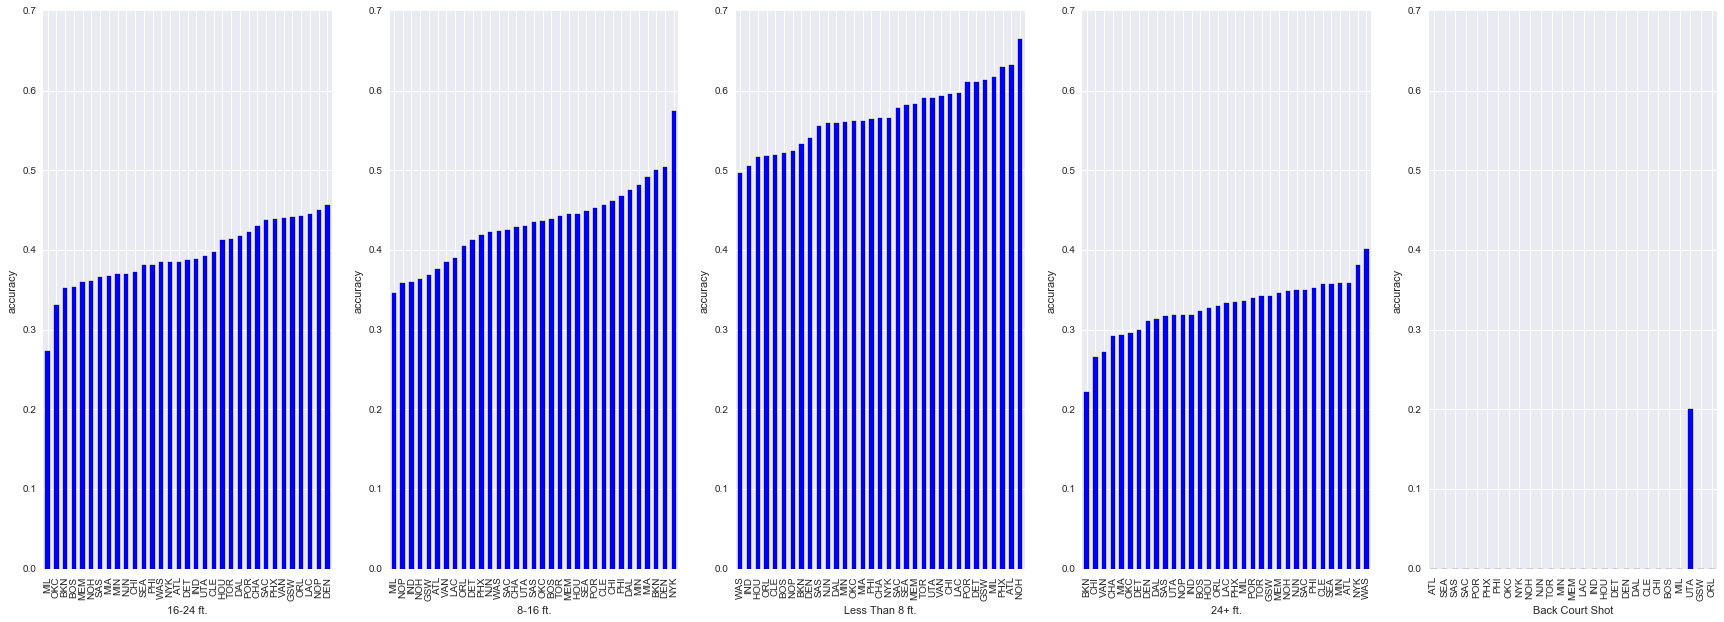

In [28]:
shot_zone_range = df['shot_zone_range'].unique()
subplot = 1
plt.figure(figsize = (30, 10))
for rang in shot_zone_range:
    plt.subplot(1, len(shot_zone_range), subplot)
    acc_opp = df['shot_made_flag'][df['shot_zone_range'] == rang].\
        groupby([df['opponent'][df['shot_zone_range'] == rang]]).mean()
    acc_opp = acc_opp.sort_values()
    acc_opp.plot(kind = 'bar')
    plt.ylabel('accuracy')
    plt.xlabel(rang)
    plt.ylim([0,0.7])
    subplot += 1

# Model

Time to predict! I chose to use patsy to quickly create a new dataframe of categorical data. I turned shot_distance into a more precise feature (and punishing for farther distances), namely squared_shot_dist.
The algo of choice was "XGBClassifier".

In [29]:
import patsy
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
import re

In [30]:
df['squared_shot_dist'] = np.sqrt(df['loc_x']**2 + df['loc_y']**2)**3
df['shot_made_flag_fill'] = df['shot_made_flag'].fillna(0)

In [31]:
store = pd.HDFStore('store.h5')
store['df'] = df
store.close()

# Restart Here

In [1]:
import csv
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.mixture import GMM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
pd.set_option('display.max_columns', 999)
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import patsy
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
import re
import cPickle

/Users/hechengwang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
store = pd.HDFStore('store.h5')
df = store['df']
store.close()

In [3]:
loc = "squared_shot_dist + pit + three_points + C(shot_zone_area) + C(shot_zone_basic) + C(shot_zone_range) + "
action = "C(combined_shot_type) + C(action_type) + "
time = "seconds_into_period + period + C(made_last_shot) + time_from_last_shot +"
game = "C(season) + C(opponent) + C(away) + C(game_id)"

y, x = patsy.dmatrices("shot_made_flag_fill ~ " + loc + action + time + game, 
                                   data=df, return_type='dataframe')
y = df['shot_made_flag']

In [4]:
x = x.rename(columns=lambda x: re.sub(r'\(|\)|\[|\]|\.|\:', "_", x))

In [5]:
x_train = x[df['shot_made_flag'].isnull() == False]
x_test = x[df['shot_made_flag'].isnull()]
y_train = y[df['shot_made_flag'].isnull() == False]
y_test = y[df['shot_made_flag'].isnull()]

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = .33)

In [7]:
xgb_train = xgb.DMatrix(X_train, label = Y_train)
xgb_test = xgb.DMatrix(X_test, label = Y_test)

In [8]:
param = {'max_depth':8, 'learning_rate':0.1, 'eval_metric': 'logloss'}
num_round = 50

In [9]:
xgb_cv = xgb.cv(param, xgb_train, num_round, nfold=5, stratified = True, 
                early_stopping_rounds=5, metrics={'logloss'}, seed = 858, verbose_eval = True)

[0]	train-logloss:0.674091+0.000646803	test-logloss:0.677725+0.000684619
[1]	train-logloss:0.658099+0.00117886	test-logloss:0.665314+0.00137275
[2]	train-logloss:0.64464+0.00158948	test-logloss:0.655129+0.0019746
[3]	train-logloss:0.633255+0.001985	test-logloss:0.646921+0.00250494
[4]	train-logloss:0.623546+0.00223255	test-logloss:0.639958+0.00322179
[5]	train-logloss:0.614873+0.00213788	test-logloss:0.634321+0.00388406
[6]	train-logloss:0.607272+0.00245844	test-logloss:0.629499+0.0043319
[7]	train-logloss:0.600651+0.00256892	test-logloss:0.625544+0.00470808
[8]	train-logloss:0.594693+0.00271296	test-logloss:0.622335+0.0051824
[9]	train-logloss:0.5894+0.00252254	test-logloss:0.619338+0.00573145
[10]	train-logloss:0.584555+0.00289152	test-logloss:0.617107+0.00611293
[11]	train-logloss:0.580272+0.00255529	test-logloss:0.615255+0.0064947
[12]	train-logloss:0.576846+0.00255731	test-logloss:0.613569+0.00690151
[13]	train-logloss:0.573168+0.0022707	test-logloss:0.61215+0.0072091
[14]	train-l

In [7]:
sss = StratifiedShuffleSplit(Y_train, 3, test_size=0.25, random_state=858)

In [9]:
import os

if __name__ == "__main__":
    os.environ["OMP_NUM_THREADS"] = "4"
    xgb_model = xgb.XGBClassifier()
    clf = GridSearchCV(xgb_model, {'max_depth': [5, 6, 7],
                                   'min_child_weight':[1, 2, 3],
                                   'n_estimators': [27],
                                   'learning_rate': [0.1]}, verbose=1,
                       scoring="log_loss",
                       cv = sss,
                       n_jobs=4)
    clf.fit(X_train, Y_train)
    print clf.best_score_
    print clf.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  6.4min finished


-0.602943687982
{'n_estimators': 27, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3}


In [10]:
test_pred = clf.predict_proba(X_test)[:,1]
print "The log-loss score on the test set is: %s" % log_loss((Y_test), test_pred)

The log-loss score on the test set is: 0.610869747238


In [8]:
import os

if __name__ == "__main__":
    os.environ["OMP_NUM_THREADS"] = "4"
    xgb_model = xgb.XGBClassifier(n_estimators = 27, learning_rate = 0.1, max_depth = 7, min_child_weight = 3)
    clf = GridSearchCV(xgb_model, {'gamma':[i/10.0 for i in range(0,5)]}, verbose=1,
                       scoring="log_loss",
                       cv = sss,
                       n_jobs=4)
    clf.fit(X_train, Y_train)
    print clf.best_score_
    print clf.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  3.9min finished


-0.602660814538
{'gamma': 0.3}


In [8]:
import os

if __name__ == "__main__":
    os.environ["OMP_NUM_THREADS"] = "4"
    xgb_model = xgb.XGBClassifier(n_estimators = 27, learning_rate = 0.1, max_depth = 7, min_child_weight = 3, gamma = 0.3)
    clf = GridSearchCV(xgb_model, {'subsample':[i/10.0 for i in range(6,10)],
                                   'colsample_bytree':[i/10.0 for i in range(6,10)]}, verbose=1,
                       scoring="log_loss",
                       cv = sss,
                       n_jobs=4)
    clf.fit(X_train, Y_train)
    print clf.best_score_
    print clf.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 10.9min finished


-0.603754558652
{'subsample': 0.6, 'colsample_bytree': 0.8}


In [9]:
test_pred = clf.predict_proba(X_test)[:,1]
print "The log-loss score on the test set is: %s" % log_loss((Y_test), test_pred)

The log-loss score on the test set is: 0.602146801353


In [8]:
import os

if __name__ == "__main__":
    os.environ["OMP_NUM_THREADS"] = "4"
    xgb_model = xgb.XGBClassifier(n_estimators = 27, learning_rate = 0.1, max_depth = 7, min_child_weight = 3, gamma = 0.3)
    clf = GridSearchCV(xgb_model, {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
                                    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]}, verbose=1,
                       scoring="log_loss",
                       cv = sss,
                       n_jobs=4)
    clf.fit(X_train, Y_train)
    print clf.best_score_
    print clf.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 20.2min finished


-0.602659997912
{'reg_alpha': 0.1, 'reg_lambda': 1}


In [9]:
test_pred = clf.predict_proba(X_test)[:,1]
print "The log-loss score on the test set is: %s" % log_loss((Y_test), test_pred)

The log-loss score on the test set is: 0.604998896293


In [10]:
cPickle.dump(clf, open("best_clf_20160908.pkl", "wb"))

In [11]:
pd.DataFrame(clf.best_estimator_.feature_importances_, index = X_train.columns.values).sort_values(0)

,0
Intercept,0.000000
C_game_id__T_21400402_,0.000000
C_game_id__T_21400392_,0.000000
C_game_id__T_21400356_,0.000000
C_game_id__T_21400351_,0.000000
C_game_id__T_21400339_,0.000000
C_game_id__T_21400315_,0.000000
C_game_id__T_21400300_,0.000000
C_game_id__T_21400279_,0.000000
C_game_id__T_21400264_,0.000000


In [12]:
basic_pred = clf.predict_proba(X_train)[:,1]
print "The log-loss score on the training set is: %s" % (log_loss((Y_train), basic_pred))

The log-loss score on the training set is: 0.578372664137


In [13]:
test_pred = clf.predict_proba(X_test)[:,1]
print "The log-loss score on the test set is: %s" % log_loss((Y_test), test_pred)

The log-loss score on the test set is: 0.604998896293


In [14]:
submission_pred = clf.predict_proba((x_test))[:,1]

In [15]:
test_ids = df[df['shot_made_flag'].isnull()]['shot_id'].values
predictions_file = open("kobe_20160908.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["shot_id","shot_made_flag"])
open_file_object.writerows(zip(test_ids, submission_pred))
predictions_file.close()

This will get you a logloss score of .6018, which made me rank 217 out of 1117.
* Before detailed-param tuning, I recieved a score of .60393, which made me rank 315.
* Before hyper-param tuning, I recieved a score of .60656, which made me rank 359.
* Before feature engineering, I recieved a score of .60827, which made me rank 441.
* Guessing ".5" on all the null values would get you a score of .69315, which corresponds with a rank of 895.
* Will look more into basketball domain knowledge to create features that explain more of the variance.